In [1]:
import pymc3 as pm

In [2]:
#import pyjags
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
n_theta = 10000

# generate 10,000 values from Beta(2,5)
theta = np.random.beta(2,5,n_theta) 
print("First five  values of theta:\n\t", theta[0:5])
print("Sample mean:\n\t", np.mean(theta))
print("The 2.5% and 97.5% of quantiles:\n\t", np.percentile(theta,[2.5,97.5])) 

First five  values of theta:
	 [0.11572802 0.35648946 0.5806408  0.45319107 0.04416077]
Sample mean:
	 0.2869748372404959
The 2.5% and 97.5% of quantiles:
	 [0.04612958 0.6401032 ]


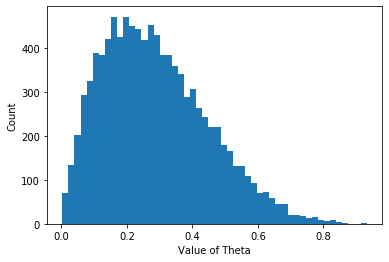

In [4]:
plt.hist(theta,50)
plt.xlabel("Value of Theta")
plt.ylabel("Count")
plt.show()

First 5 heads/tails values (tails=0, heads=1)
	 [0 0 1 0 0 1 0 1 0 1]
Overall frequency of Tails and Heads, accounting for uncertainty about theta itself
	 [0.7082 0.2918]


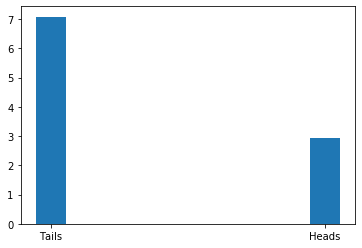

In [5]:
# simulate y from posterior predictive distribution
y = np.random.binomial(1, theta, n_theta) # generate a heads/tails value from each of the 10,000 thetas

print("First 5 heads/tails values (tails=0, heads=1)\n\t", y[0:10])
print("Overall frequency of Tails and Heads, accounting for uncertainty about theta itself\n\t", np.bincount(y)/10000)

plt.hist(y, density=True)
plt.xticks([.05,.95],["Tails","Heads"])
plt.show()

## Beetles

In [6]:
beetles_x = np.array([1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.8610, 1.8839])
beetles_x_mean = beetles_x - np.mean(beetles_x)
beetles_n = np.array([59, 60, 62, 56, 63, 59, 62, 60])
beetles_y = np.array([6, 13, 18, 28, 52, 53, 61, 60])
beetles_N = np.array([8]*8)

In [7]:
from scipy.special import expit
expit(2)

0.8807970779778823

In [8]:
with pm.Model() as beetle_model:
    # The intercept (log probability of beetles dying when dose=0)
    # is centered at zero, and wide-ranging (easily anywhere from 0 to 100%)
    # If we wanted, we could choose something like Normal(-3,2) for a no-dose
    # death rate roughly between .007 and .25
    alpha_star = pm.Normal('alpha*', mu=0, sigma=100)
    # the effect on the log-odds of each unit of the dose is wide-ranging:
    # we're saying we've got little idea what the effect will be, and it could
    # be strongly negative.
    beta = pm.Normal('beta', mu=0, sigma=100)
    
    # given alpha, beta, and the dosage, the probability of death is deterministic:
    # it's the inverse logit of the intercept+slope*dosage
    # Because beetles_x has 8 entries, we end up with 8 p_i values
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(alpha_star + beta*beetles_x_mean))
    
    # finally, the number of bettles we see killed is Binomial(n=number of beetles, p=probability of death)
    deaths = pm.Binomial('obs_deaths', n=beetles_n, p=p_i, observed=beetles_y)
    
    trace = pm.sample(2000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha*]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:03<00:00, 4738.25draws/s]


/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

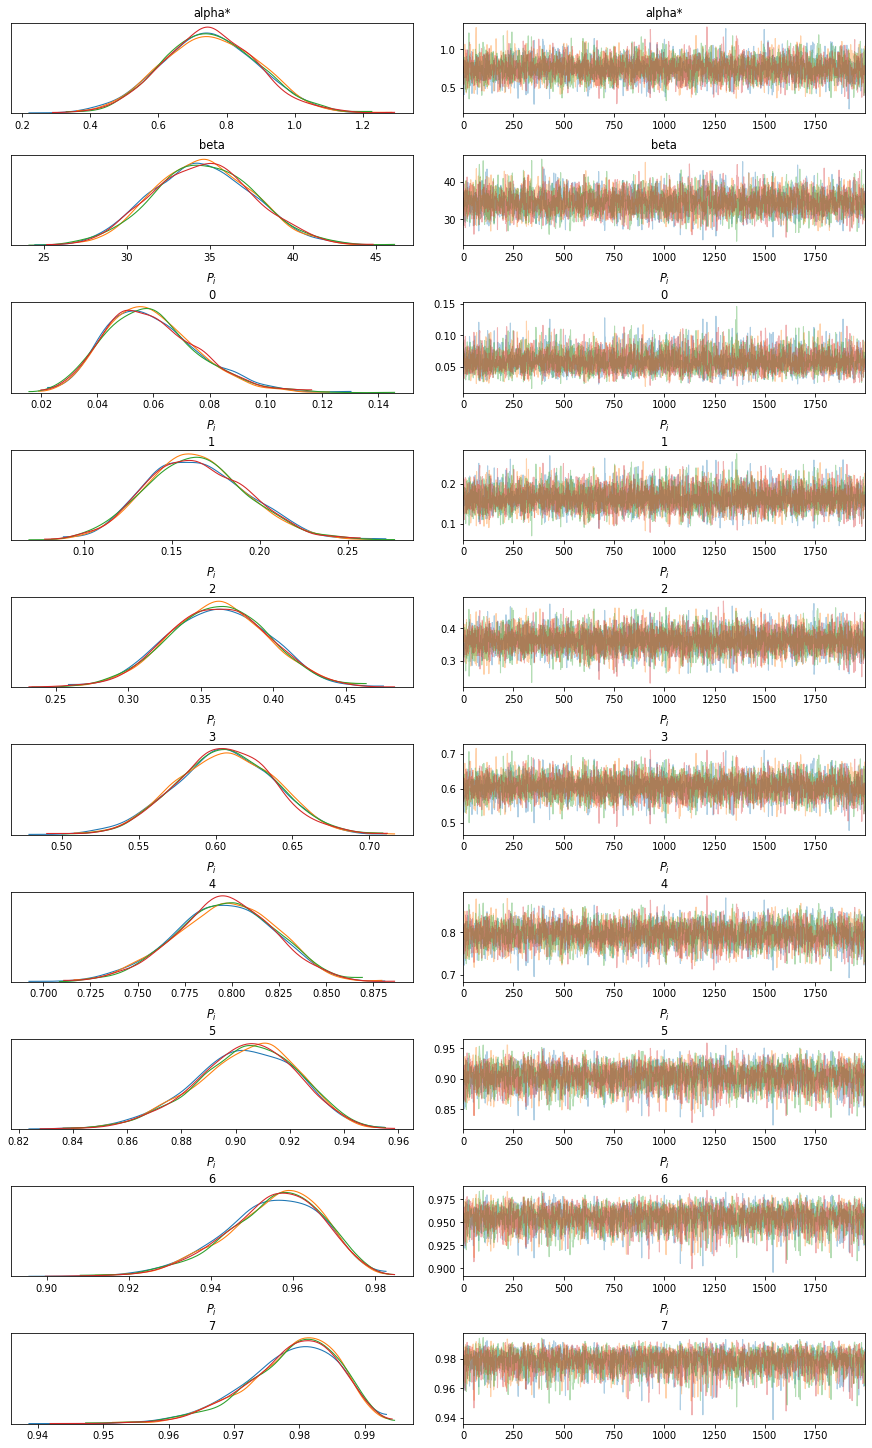

In [10]:
pm.traceplot(trace, compact=False);

In [11]:
def trace_summary(trace, var_names=None):
    if var_names is None:
        var_names = trace.varnames

    quants = [0.025,0.25,0.5,0.75,0.975]
    colnames = ['mean', 'sd', *["{}%".format(x*100) for x in quants]]
    rownames = []

    series = []
    for cur_var in var_names:
        var_trace = trace[cur_var]
        if var_trace.ndim == 1:
            vals = [np.mean(var_trace, axis=0), np.std(var_trace, axis=0), *np.quantile(var_trace, quants, axis=0)]
            series.append(pd.Series(vals, colnames))
            rownames.append(cur_var)
        else:
            for i in range(var_trace.shape[1]):
                cur_col = var_trace[:,i]
                vals = [np.mean(cur_col, axis=0), np.std(cur_col, axis=0), *np.quantile(cur_col, quants, axis=0)]
                series.append(pd.Series(vals, colnames))
                rownames.append("{}[{}]".format(cur_var,i))

    return pd.DataFrame(series, index=rownames)

trace_summary(trace)

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
alpha*,0.750655,0.139552,0.486770,0.655694,0.747606,0.846309,1.028829
beta,34.589557,2.997825,28.913545,32.490112,34.556914,36.613834,40.587448
$P_i$[0],0.059266,0.016352,0.032128,0.047367,0.057675,0.069105,0.095215
$P_i$[1],0.163965,0.028536,0.111709,0.143873,0.162499,0.182540,0.221798
$P_i$[2],0.361608,0.034439,0.294641,0.337952,0.361619,0.385119,0.428243
$P_i$[3],0.605797,0.031732,0.544426,0.584467,0.606142,0.628105,0.666668
$P_i$[4],0.795919,0.026458,0.741935,0.778705,0.796437,0.814387,0.845600
$P_i$[5],0.903378,0.018901,0.863455,0.891313,0.904542,0.916997,0.936708
$P_i$[6],0.954910,0.011961,0.928685,0.947518,0.956120,0.963545,0.974894
$P_i$[7],0.978651,0.007133,0.962322,0.974443,0.979588,0.983817,0.989747


We can also plot the density each chain explored. Any major deviations between chains are signs of difficulty converging.

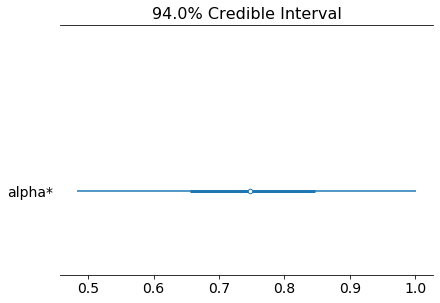

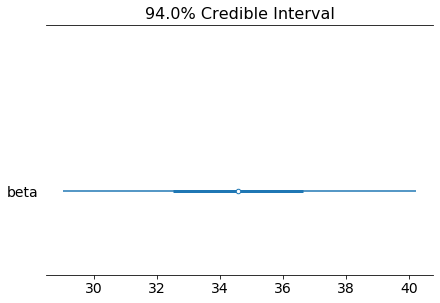

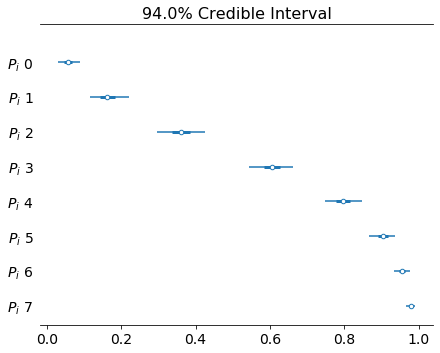

In [12]:
for x in trace.varnames:
    pm.plot_forest(trace, var_names=[x], combined=True)

In addition to the above summaries of the distribution, pymc3 has statistics intended to summarize the quality of the samples. The most common of these is r_hat, which measures whether the different chains seem to be exploring the same space or if they're stuck in different spaces. R-hat above 1.3 is a strong sign the sample isn't good yet. Values close to 1 are ideal.

In [13]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha*,0.751,0.140,0.483,1.001,0.002,0.001,4714.0,4629.0,4726.0,4555.0,1.0
beta,34.590,2.998,29.022,40.201,0.046,0.032,4329.0,4270.0,4347.0,4462.0,1.0
$P_i$[0],0.059,0.016,0.030,0.090,0.000,0.000,5922.0,5759.0,5840.0,4598.0,1.0
$P_i$[1],0.164,0.029,0.115,0.221,0.000,0.000,6808.0,6733.0,6724.0,4736.0,1.0
$P_i$[2],0.362,0.034,0.297,0.425,0.000,0.000,7321.0,7321.0,7315.0,4656.0,1.0
$P_i$[3],0.606,0.032,0.544,0.662,0.000,0.000,5338.0,5335.0,5341.0,5096.0,1.0
$P_i$[4],0.796,0.026,0.747,0.846,0.000,0.000,4125.0,4106.0,4087.0,4087.0,1.0
$P_i$[5],0.903,0.019,0.867,0.937,0.000,0.000,3888.0,3876.0,3810.0,3872.0,1.0
$P_i$[6],0.955,0.012,0.933,0.976,0.000,0.000,3919.0,3912.0,3787.0,3915.0,1.0
$P_i$[7],0.979,0.007,0.966,0.991,0.000,0.000,3996.0,3992.0,3816.0,3948.0,1.0


## Sleep Study

In [16]:
import pandas as pd
sleepstudy = pd.read_csv("../data/sleepstudy.csv")

In [17]:
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
5,414.6901,5,308
6,382.2038,6,308
7,290.1486,7,308
8,430.5853,8,308
9,466.3535,9,308


In [18]:
# adding a column that numbers the subjects from 0 to n
raw_ids = np.unique(sleepstudy['Subject'])
raw2newid = {x:np.where(raw_ids == x)[0][0] for x in raw_ids}

sleepstudy['SeqSubject'] = sleepstudy['Subject'].map(raw2newid)
sleepstudy

,Reaction,Days,Subject,SeqSubject
0,249.5600,0,308,0
1,258.7047,1,308,0
2,250.8006,2,308,0
3,321.4398,3,308,0
4,356.8519,4,308,0
5,414.6901,5,308,0
6,382.2038,6,308,0
7,290.1486,7,308,0
8,430.5853,8,308,0
9,466.3535,9,308,0


In [19]:
with pm.Model() as sleep_model:
    
    # In this model, we're going to say the alphas (individuals' intercepts; their starting reaction time)
    # and betas (individuals' slopes; how much worse they get with lack of sleep) are normally distributed.
    # We'll specify that we're certain about the mean of those distribution [more on that later], but admit
    # we're uncertain about how much spread there is (i.e. uncertain about the SD). Tau_alpha and Tau_beta 
    # will be the respective SD.
    #
    # Of course, the SDs must be positive (negative SD isn't mathematically possible), so we draw them from
    # a Gamma, which cannot ever output negative numbers. Here, we use alpha and beta values that spread the
    # distribution: "the SD could be anything!". If we had more intuition (e.g. "the starting reaction times can't
    # have SD above 3,000") we would plot Gamma(a,b) and tune the parameters so that there was little mass
    # above 3,000, then use those values below)
    tau_alpha = pm.Gamma('tau_alpha', alpha=.001, beta=.001)
    tau_beta = pm.Gamma('tau_beta', alpha=.001, beta=.001)
    
    # Across the population of people, we suppose that
    # the slopes are normally distributed, as are the intercepts,
    # and the two are drawn independently
    #
    # (Here, we hard-code assumed means, but we don't have to.
    # In general, these should be set from our pre-data intuition,
    # rather than from plots/exploration of the data)
    alpha = pm.Normal('alpha', mu=300, tau=tau_alpha, shape=len(raw_ids))
    beta = pm.Normal('beta', mu=10, tau=tau_beta, shape=len(raw_ids))
    
    # Remember: there's only one alpha/beta per person, but
    # we have lots of observations per person. The below
    # builds a vector with one entry per observation, recording
    # the alpha/beta we want to use with that observation.
    #
    # That is, the length is 180, but it only has 17 unique values,
    # matching the 17 unique patients' personal slopes or intercepts
    intercepts = alpha[sleepstudy['SeqSubject']]
    slopes = beta[sleepstudy['SeqSubject']]
    
    # now we have the true/predicted response time for each observation (each row of original data)
    # (Here we use pm.Deterministic to signal that this is something we'll care about)
    mu_i = pm.Deterministic('mu_i', intercepts + slopes*sleepstudy['Days'])
    
    # The _observed_ values are noisy versions of the hidden true values, however! 
    # Specifically, we model them as a normal at the true value and single unknown variance
    # (one explanation: we're saying the measurement equipment adds normally-distributed noise tau_obs
    # so noise doesn't vary from observation to observation or person to person: there's just one universal
    # noise level)
    tau_obs = pm.Gamma('tau_obs', 0.001, 0.001)
    obs = pm.Normal('observed', mu=mu_i, tau=tau_obs, observed=sleepstudy['Reaction'])
    
    trace = pm.sample(2000, tune=2000, target_accept=0.9)

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_obs, beta, alpha, tau_beta, tau_alpha]
/Users/wseaton/opt/an

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.p

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


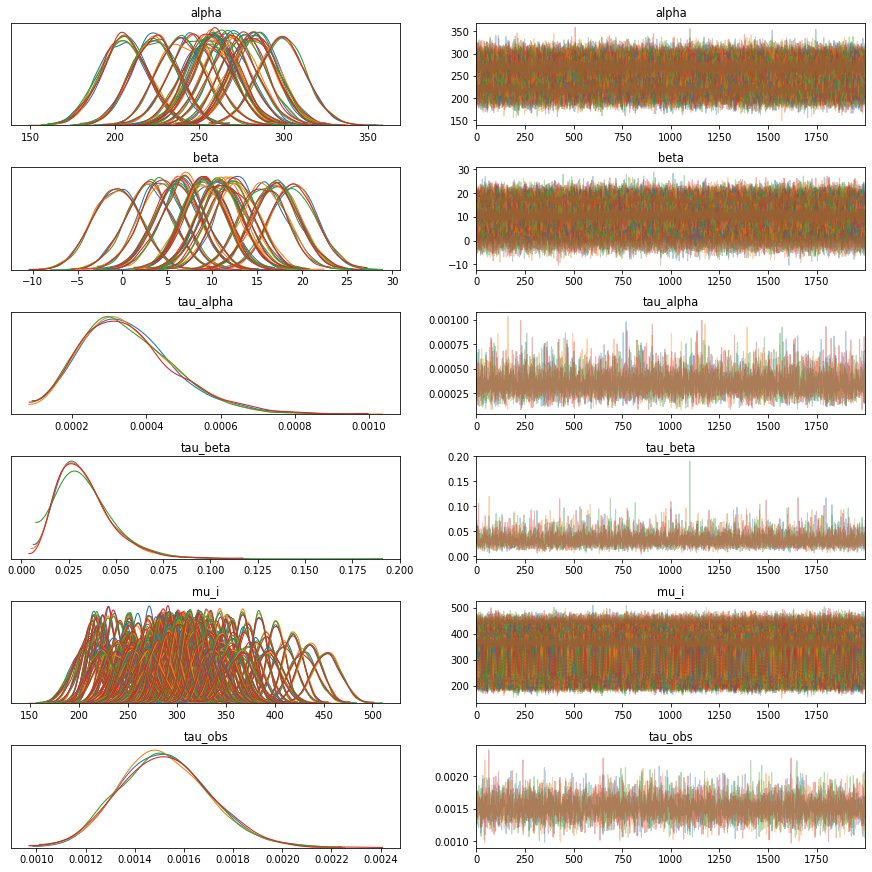

In [20]:
# this command can take a few minutes to finish... or never :-/
pm.traceplot(trace);

In [21]:
trace_summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
tau_alpha,0.000351,0.000129,0.000147,0.000260,0.000334,0.000425,0.000646
tau_beta,0.033327,0.014716,0.013133,0.022843,0.030616,0.040538,0.069112
alpha[0],258.080601,14.091503,230.619661,248.643993,257.875169,267.555084,286.058749
alpha[1],204.605810,14.084662,177.273967,195.113290,204.663177,214.265390,232.172322
alpha[2],206.127016,13.845724,179.060427,196.978383,205.939445,215.353686,233.170263
alpha[3],284.198146,13.475663,257.782107,275.226758,284.101025,293.068408,310.952698
alpha[4],282.447261,13.449256,256.548861,273.407538,282.439450,291.500794,308.658743
alpha[5],265.965682,13.552667,239.637021,256.824946,266.035115,274.913915,292.511661
alpha[6],275.831108,13.488871,249.642762,266.640745,275.907013,284.930287,302.510197
alpha[7],245.915053,13.911599,218.520822,236.779181,245.934651,254.961972,274.063599


In [22]:
pm.summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau_alpha,0.000,0.000,0.000,0.001,0.000,0.000,11925.0,10790.0,11563.0,6085.0,1.0
tau_beta,0.033,0.015,0.011,0.060,0.000,0.000,8289.0,7237.0,8601.0,6319.0,1.0
alpha[0],258.081,14.092,232.016,284.594,0.128,0.090,12180.0,12167.0,12204.0,6335.0,1.0
alpha[1],204.606,14.086,177.854,230.967,0.130,0.092,11754.0,11754.0,11753.0,6488.0,1.0
alpha[2],206.127,13.847,180.630,232.716,0.122,0.086,12911.0,12868.0,12957.0,6212.0,1.0
alpha[3],284.198,13.477,259.189,310.295,0.127,0.090,11217.0,11217.0,11226.0,6136.0,1.0
alpha[4],282.447,13.450,256.717,306.852,0.120,0.085,12564.0,12520.0,12581.0,5758.0,1.0
alpha[5],265.966,13.554,240.035,290.854,0.120,0.085,12726.0,12581.0,12708.0,6146.0,1.0
alpha[6],275.831,13.490,250.149,300.608,0.123,0.087,11955.0,11955.0,11942.0,6205.0,1.0
alpha[7],245.915,13.912,220.170,273.220,0.127,0.090,11990.0,11941.0,12093.0,5800.0,1.0


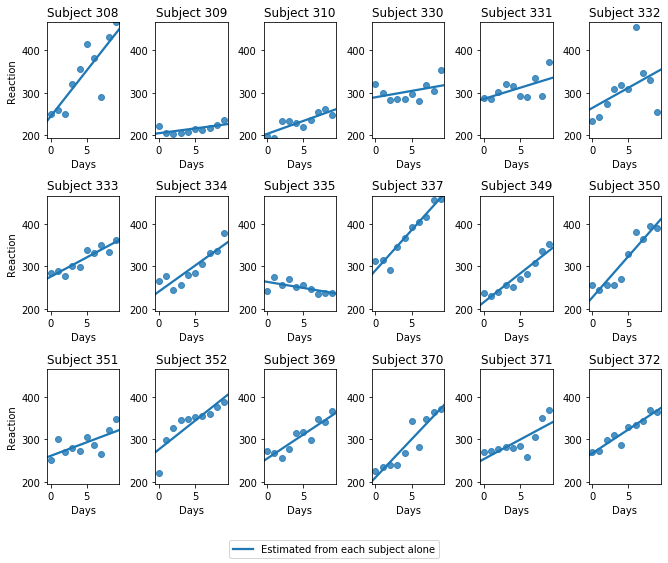

In [23]:
import statsmodels.formula.api as sm
import seaborn as sns
from matplotlib import gridspec


ymin,ymax = np.min(sleepstudy["Reaction"]),np.max(sleepstudy["Reaction"])
plt.figure(figsize=(11,8.5))
gs  = gridspec.GridSpec(3, 6)
gs.update(wspace=0.5, hspace=0.5)
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    ss_extract_ols = sm.ols(formula="Reaction~Days",data=ss_extract).fit()
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj))
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone'],loc = 'lower center', ncol=6)
_ = plt.show()

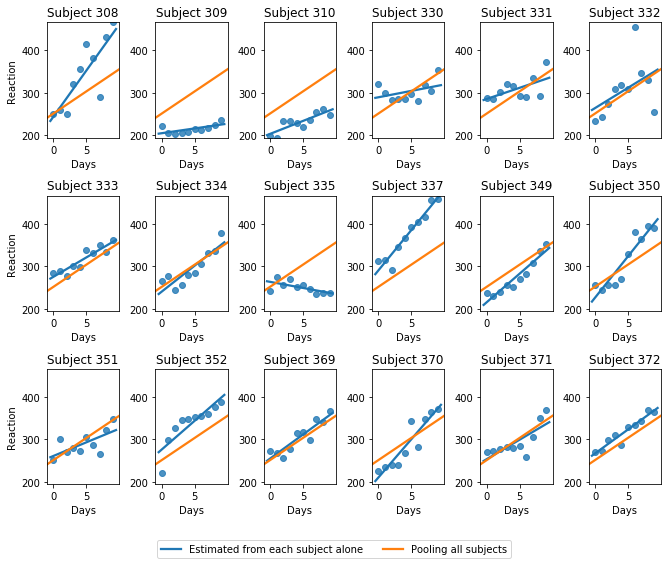

In [24]:
plt.figure(figsize=(11,8.5))
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects'],loc = 'lower center', ncol=6)
_ = plt.show()

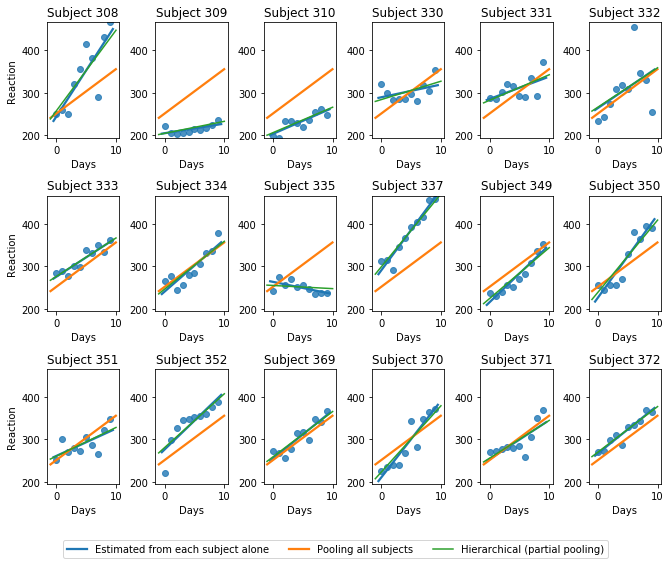

In [23]:
plt.figure(figsize=(11,8.5))
subj_arr = np.unique(sleepstudy['Subject'])
for i, subj in enumerate(subj_arr):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    
    subj_num = int(np.where(subj_arr==subj)[0])
    
    subjects_avg_intercept = np.mean(trace['alpha'][:,i])
    subjects_avg_slope = np.mean(trace['beta'][:,i])
    hmodel_fit = [subjects_avg_intercept + subjects_avg_slope*x for x in range(-1,11)]
    sns.lineplot(x=range(-1,11),y=hmodel_fit)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects','Hierarchical (partial pooling)'],loc = 'lower center', ncol=6)
_ = plt.show()

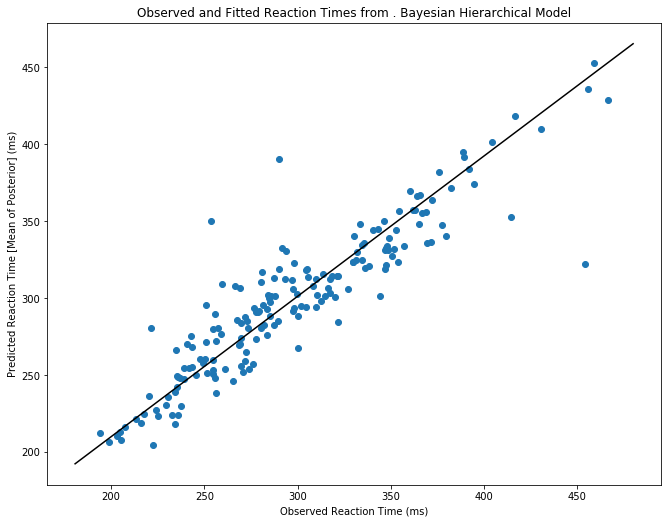

In [24]:
model_predictions = trace['mu_i'].mean(axis=0)
obs_reactions = sleepstudy['Reaction']

plt.figure(figsize=(11,8.5))
plt.scatter(sleepstudy['Reaction'], model_predictions)
plt.plot(plt.xlim(), plt.ylim(), c='black')
plt.xlabel("Observed Reaction Time (ms)")
plt.ylabel("Predicted Reaction Time [Mean of Posterior] (ms)")
plt.title("Observed and Fitted Reaction Times from . Bayesian Hierarchical Model")
plt.show()